# Wine dataset: Implementing a Multiclass Classifier

**D3APL: Aplicações em Ciências de Dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

## 1. Set up

### Imports

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

### Graph styles

In [2]:
sns.set_theme(
    style='white',
    rc={
        'axes.titlesize': 16,
        'axes.labelsize': 12,
        'axes.spines.top': False,
        'axes.spines.right': False,
    }
)

#### Creating fake data

In [3]:
X, y = make_blobs(n_samples=2000, n_features=2, centers=4, cluster_std=2, random_state=42)

y = np.array([f'Class {c + 1}' for c in y])

labels = np.sort(np.unique(y))

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')
print(f'Labels: {labels}')

X.shape: (2000, 2)
y.shape: (2000,)
Labels: ['Class 1' 'Class 2' 'Class 3' 'Class 4']


In [4]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (1600, 2)
y_train.shape = (1600,)
X_test.shape = (400, 2)
y_test.shape = (400,)


In [5]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

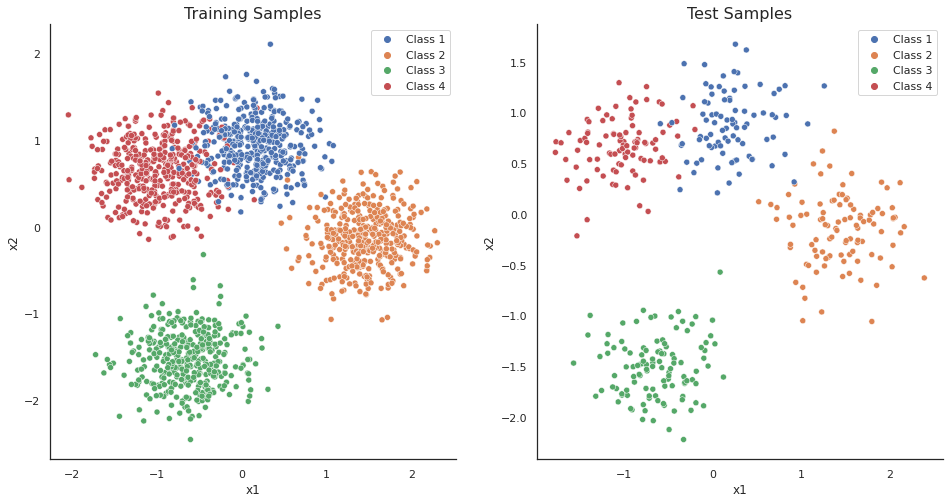

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, hue_order=labels, ax=ax[0])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, hue_order=labels, ax=ax[1])

ax[0].set(xlabel='x1', ylabel='x2', title='Training Samples')
ax[1].set(xlabel='x1', ylabel='x2', title='Test Samples')

plt.show()

## 2. Implementation

In [7]:
from typing import Tuple

import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.base import BaseEstimator, ClassifierMixin


class LogisticRegression(ClassifierMixin, BaseEstimator):
    """Logistic Regression Classifier with SDG training.
    
    Parameters
    ----------
    learning_rate : float, default=0.001
        Learning rate.

    n_epochs : int, default=1000
        Number of epochs for training (convergence stop).

    alpha : float, default=0.0001
        Constant that multiplies the regularization term.
        Use 0 to ignore regularization (standard Logistic Regression).
        
    optimizer : str, defatult='batch'
        Gradient descent optimizer strategy
        
    minibatch_size : int, default=20
        Batch size when optimizer='mini'

    random_state : int, default=42
        Seed used for generating random numbers.
        
    Attributes
    ----------
    coef_ : ndarray of shape (1, n_features) if n_classes == 2 else \
            (n_classes, n_features)
        Weights assigned to the features.
        
    intercept_ : ndarray of shape (1,) if n_classes == 2 else (n_classes,)
        Intercept (a.k.a. bias) added to the decision function.
    """
    
    def __init__(
        self,
        learning_rate: float = 0.001,
        n_epochs: int = 1000,
        alpha: float = 0.0001,
        optimizer: str = "batch",
        minibatch_size: int = 20,
        random_state: int = 42
    ):

        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        assert (alpha is not None) and (alpha >= 0), \
        f'Alpha should be >= 0. Passed: {alpha}'
        
        assert optimizer in ['batch', 'mini', 'stochastic'], \
        f'Optimizer "{optimizer}" is not supported'
        
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.optimizer = optimizer
        self.minibatch_size = minibatch_size
        self.random_state = random_state
        
        
        # parameters to be trained/learned
        self.__w = None  # weight array
        self.__b = None  # bias
        
        self.__classes = None
    
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f"""
        Learning rate: {self.learning_rate}
        Number of epochs: {self.n_epochs}
        Regularization constant (alpha): {self.alpha}
        Optimizer (optimizer): {self.optimizer}
        Random state: {self.random_state}
        
        Trained?: {self.is_fitted()}
        """

        return msg
    
    
    @property
    def classes_(self) -> ndarray:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__classes
    
    @property
    def n_classes_(self) -> int:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return len(self.__classes)
    
    @property
    def multilabel_(self) -> int:
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__classes > 2
    
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    

    @property
    def intercept_(self) -> ndarray:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        """Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant. 

        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        """
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(
        self,
        X: ndarray,
        y: ndarray,
        p_hat: ndarray,
        w: ndarray,
        alpha: float
    ) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        w : ndarray, shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        
        regularization = alpha * w
        
        error = p_hat - y  # shape (n_samples,)
        grad_w = (np.dot(error, X) / n_samples) + regularization  # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b
    
    def __shuffle(self, X: ndarray, y: ndarray) -> Tuple[ndarray, ndarray]:
        p = np.random.permutation(len(y))
        return X[p], y[p]

    
    def __binary_fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # alternatively
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        ### PARAMETER INITIALIZATION
        # return values from the “standard normal” distribution.
        w = np.random.randn(n_features)  # shape: (n_features,)
        b = np.random.randn()
        
        # values of each iteration
        losses = []
        weights = [w]
        biases = [b]
        
        if self.optimizer == 'stochastic':
            batch_size = 1
        elif self.optimizer == 'mini':
            batch_size = self.minibatch_size
        else:
            batch_size = n_samples
        
        # LEARNING ITERATIONS
        for epoch in range(self.n_epochs):
            X, y = self.__shuffle(X, y)
            for i in range(0, n_samples, batch_size):
                X_b = X[i:i + batch_size]
                y_b = y[i:i + batch_size]
                
                ### ESTIMATION (FORWARD PASS)
                z = np.dot(X_b, w) + b
                p_hat = self.__sigmoid(z)
            
                ### LOSS
                J = self.__log_loss(y_b, p_hat)
            
                ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                grad_w, grad_b = self.__gradient(X_b, y_b, p_hat, w, self.alpha)
                w = w - self.learning_rate * grad_w
                b = b - self.learning_rate * grad_b
                
                losses.append(J)
                weights.append(w)
                biases.append(b)
                            
            if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={J:.7f}')
        
        if verbose:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
            
            fig = plt.figure(figsize=(16,8), tight_layout=True)
            gs = GridSpec(3, 3, figure=fig)
            
            ax1 = fig.add_subplot(gs[:, :-1])
            ax2 = fig.add_subplot(gs[0, -1])
            ax3 = fig.add_subplot(gs[1, -1])
            ax4 = fig.add_subplot(gs[2, -1])
            
            w_lines = weights[:-1:verbose] + [ weights[-1] ]
            b_lines = biases[:-1:verbose] + [ biases[-1] ]
            colors = sns.color_palette("crest", n_colors=len(w_lines))
            for i, (w1, w2), b in zip(range(len(w_lines)), w_lines, b_lines):
                x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
                x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
                sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax1)
                
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1, zorder=99)
                
            ax1.set_xlabel('x1')
            ax1.set_ylabel('x2')
            ax1.set_xlim(X[:, 0].min(), X[:, 0].max())
            ax1.set_ylim(X[:, 1].min(), X[:, 1].max())
            ax1.set_title('Updates of Decision Boundary on Training Samples')
            
            weights = np.array(weights)
            biases = np.array(biases)
            sns.lineplot(x=weights[:, 0], y=biases, ax=ax2)
            ax2.set(title="Evolution of w1 x b", xlabel="w1", ylabel="b")
            
            sns.lineplot(x=weights[:, 1], y=biases, ax=ax3)
            ax3.set(title="Evolution of w2 x b", xlabel="w2", ylabel="b")
            
            sns.lineplot(x=weights[:, 0], y=weights[:, 1], ax=ax4)
            ax4.set(title="Evolution of w1 x w2", xlabel="w1", ylabel="w2")
            
            plt.show()
            
        return weights[-1], biases[-1]
            
    
    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        self.__classes = np.unique(y)
        
        classes = self.__classes if len(self.__classes) > 2 else self.__classes[-1:]
            
        w, b = [], []
        for label in classes:
            y_label = np.array([1 if l == label else 0 for l in y])
            w_label, b_label = self.__binary_fit(X, y_label, verbose)
            w.append(w_label)
            b.append(b_label)
            
        self.__w = np.array(w)
        self.__b = np.array(b)
            
        return self
    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        z = np.dot(X, self.__w.T) + self.__b
        p_hat = self.__sigmoid(z)
        
        return p_hat  
        
        
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'
        
        p_hat = self.predict_proba(X)
        
        y_hat = np.argmax(p_hat, axis=1) if len(self.__classes) > 2 else (p_hat[:, 0] >= 0.5).astype(int)
        
        return self.classes_[y_hat]

### Testing `fit()`

#### Batch

[INFO] epoch=1/1000, loss=0.9440045
[INFO] epoch=100/1000, loss=0.7610175
[INFO] epoch=200/1000, loss=0.6434155
[INFO] epoch=300/1000, loss=0.5684532
[INFO] epoch=400/1000, loss=0.5190901
[INFO] epoch=500/1000, loss=0.4851461
[INFO] epoch=600/1000, loss=0.4607202
[INFO] epoch=700/1000, loss=0.4423691
[INFO] epoch=800/1000, loss=0.4280383
[INFO] epoch=900/1000, loss=0.4164667
[INFO] epoch=1000/1000, loss=0.4068555

Final loss: 0.4068554935654765

Mean loss: 0.538033064031745 +- 0.13512376733520282


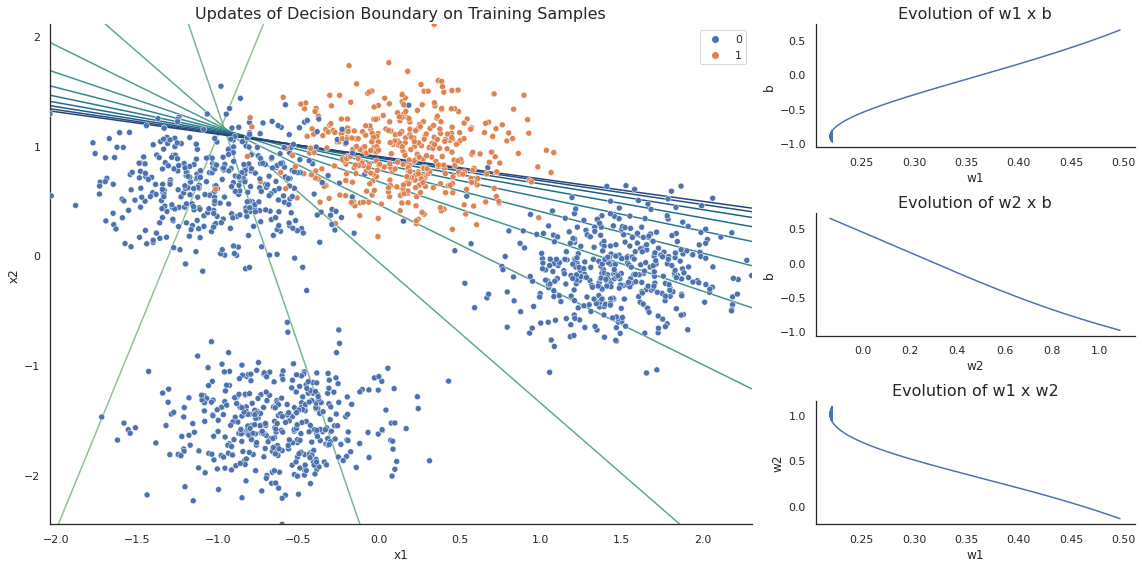

[INFO] epoch=1/1000, loss=0.7509883
[INFO] epoch=100/1000, loss=0.5721968
[INFO] epoch=200/1000, loss=0.4588730
[INFO] epoch=300/1000, loss=0.3846776
[INFO] epoch=400/1000, loss=0.3334156
[INFO] epoch=500/1000, loss=0.2962056
[INFO] epoch=600/1000, loss=0.2680392
[INFO] epoch=700/1000, loss=0.2459657
[INFO] epoch=800/1000, loss=0.2281664
[INFO] epoch=900/1000, loss=0.2134725
[INFO] epoch=1000/1000, loss=0.2011039

Final loss: 0.20110388336593948

Mean loss: 0.34574334184139804 +- 0.13884157642752082


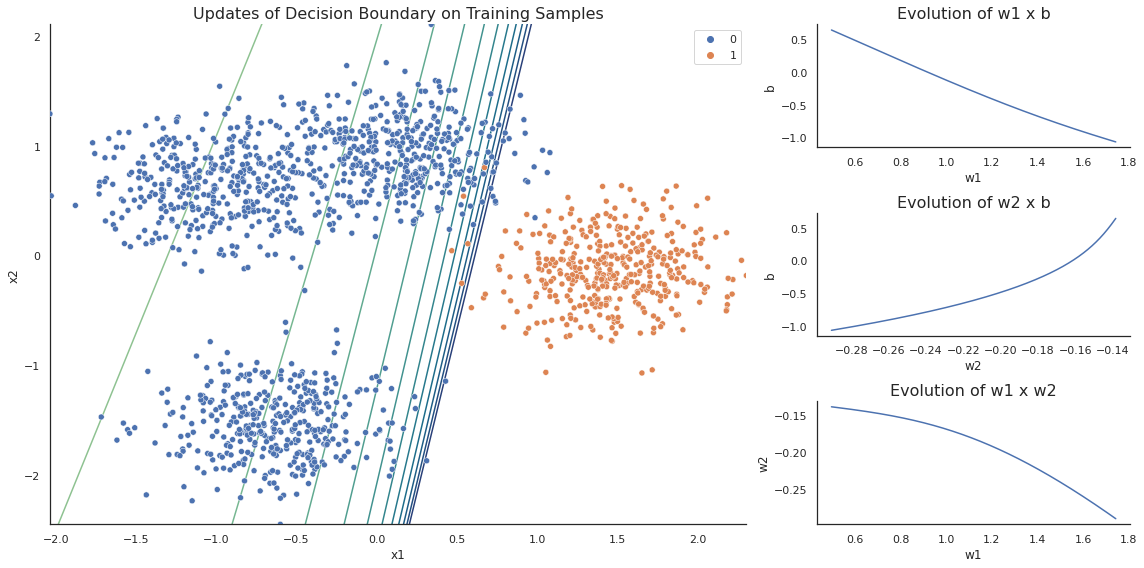

[INFO] epoch=1/1000, loss=0.9647026
[INFO] epoch=100/1000, loss=0.6845431
[INFO] epoch=200/1000, loss=0.5081444
[INFO] epoch=300/1000, loss=0.3981067
[INFO] epoch=400/1000, loss=0.3263682
[INFO] epoch=500/1000, loss=0.2769873
[INFO] epoch=600/1000, loss=0.2412541
[INFO] epoch=700/1000, loss=0.2142913
[INFO] epoch=800/1000, loss=0.1932411
[INFO] epoch=900/1000, loss=0.1763462
[INFO] epoch=1000/1000, loss=0.1624764

Final loss: 0.16247641835050886

Mean loss: 0.3552403621956825 +- 0.20016160070505495


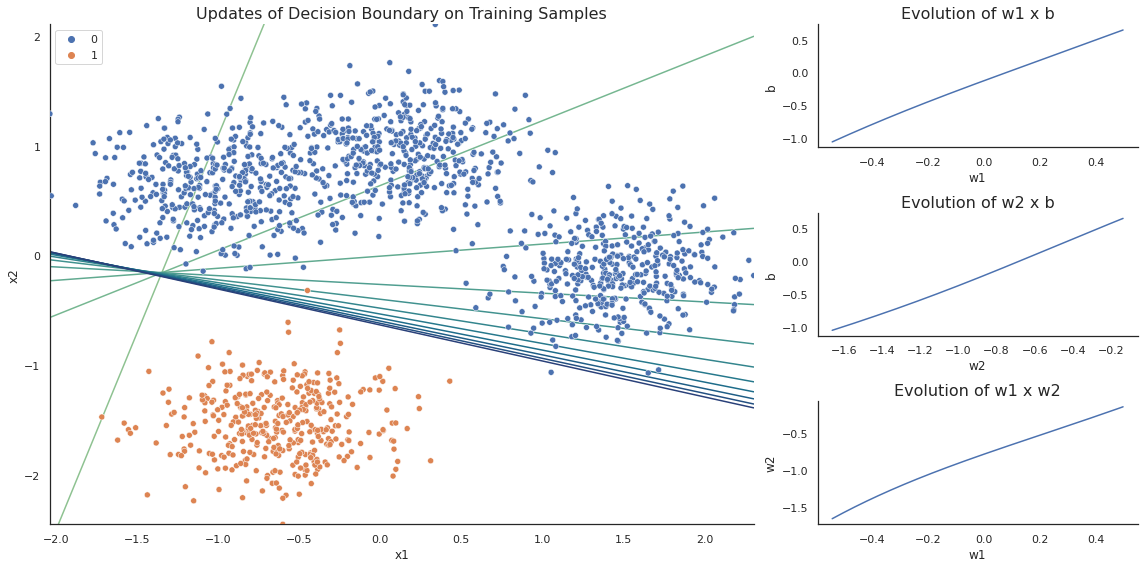

[INFO] epoch=1/1000, loss=1.0787626
[INFO] epoch=100/1000, loss=0.8196904
[INFO] epoch=200/1000, loss=0.6520587
[INFO] epoch=300/1000, loss=0.5481951
[INFO] epoch=400/1000, loss=0.4813192
[INFO] epoch=500/1000, loss=0.4355701
[INFO] epoch=600/1000, loss=0.4024270
[INFO] epoch=700/1000, loss=0.3772443
[INFO] epoch=800/1000, loss=0.3573645
[INFO] epoch=900/1000, loss=0.3411848
[INFO] epoch=1000/1000, loss=0.3276899

Final loss: 0.32768989503098067

Mean loss: 0.5090801455675024 +- 0.18798812888620606


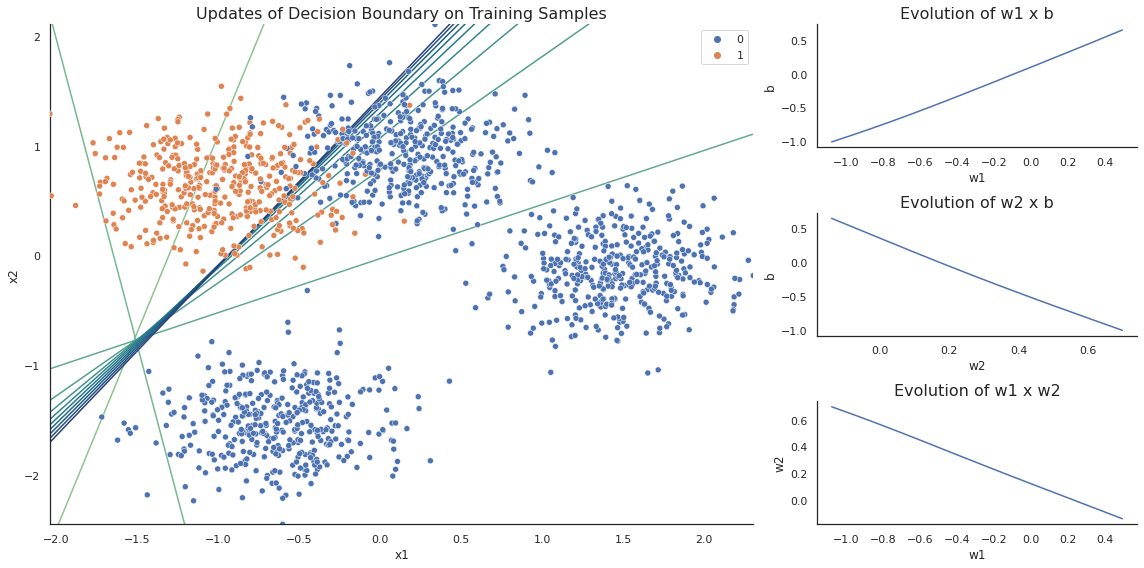

LogisticRegression(learning_rate=0.01)

In [18]:
clf = LogisticRegression(learning_rate=0.01)
clf.fit(X_train, y_train, verbose=100)

#### Mini

[INFO] epoch=1/50, loss=0.8760280
[INFO] epoch=10/50, loss=0.6880457
[INFO] epoch=20/50, loss=0.5903870
[INFO] epoch=30/50, loss=0.4859200
[INFO] epoch=40/50, loss=0.4672059
[INFO] epoch=50/50, loss=0.4366794

Final loss: 0.4366793968250607

Mean loss: 0.5683775289807909 +- 0.13684727667918503


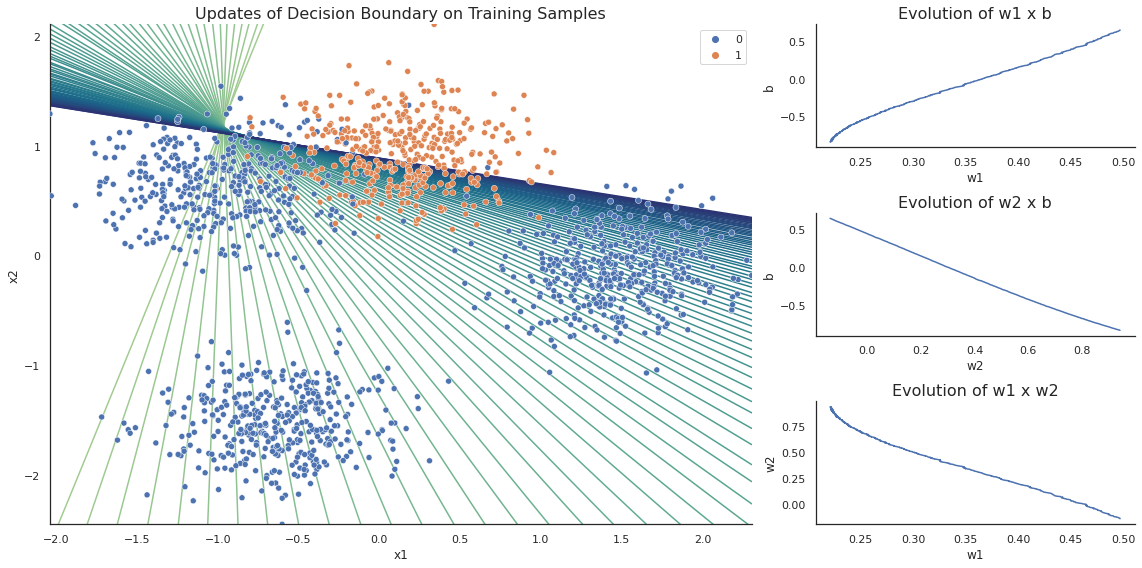

[INFO] epoch=1/50, loss=0.7756889
[INFO] epoch=10/50, loss=0.4850917
[INFO] epoch=20/50, loss=0.3425164
[INFO] epoch=30/50, loss=0.2803685
[INFO] epoch=40/50, loss=0.2425990
[INFO] epoch=50/50, loss=0.2511694

Final loss: 0.25116935860840917

Mean loss: 0.37873505197972307 +- 0.13799957366224314


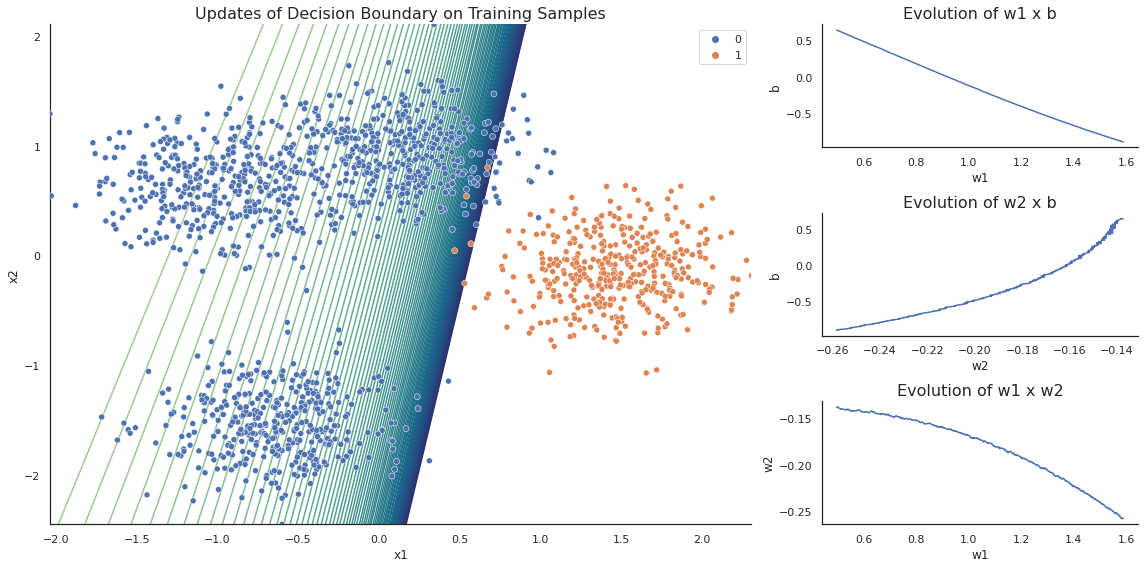

[INFO] epoch=1/50, loss=0.8148804
[INFO] epoch=10/50, loss=0.5705186
[INFO] epoch=20/50, loss=0.4063623
[INFO] epoch=30/50, loss=0.2898631
[INFO] epoch=40/50, loss=0.2404398
[INFO] epoch=50/50, loss=0.1965638

Final loss: 0.19656375214507046

Mean loss: 0.39986545959751096 +- 0.20112805157888947


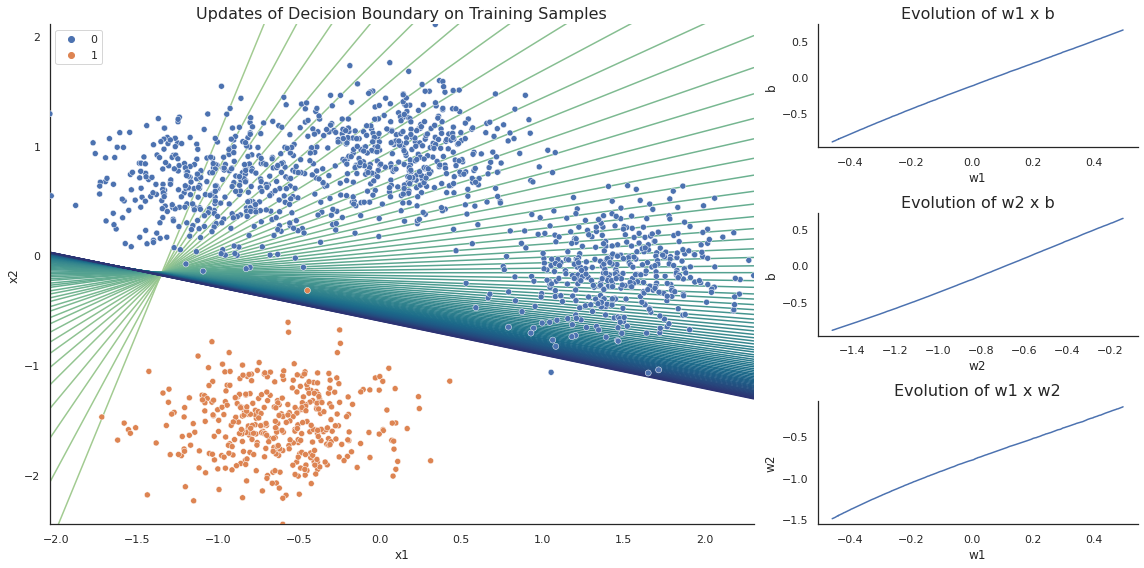

[INFO] epoch=1/50, loss=1.0183728
[INFO] epoch=10/50, loss=0.7116955
[INFO] epoch=20/50, loss=0.5228281
[INFO] epoch=30/50, loss=0.4304467
[INFO] epoch=40/50, loss=0.3941897
[INFO] epoch=50/50, loss=0.3312866

Final loss: 0.33128655422839165

Mean loss: 0.550980712925114 +- 0.18886199777633897


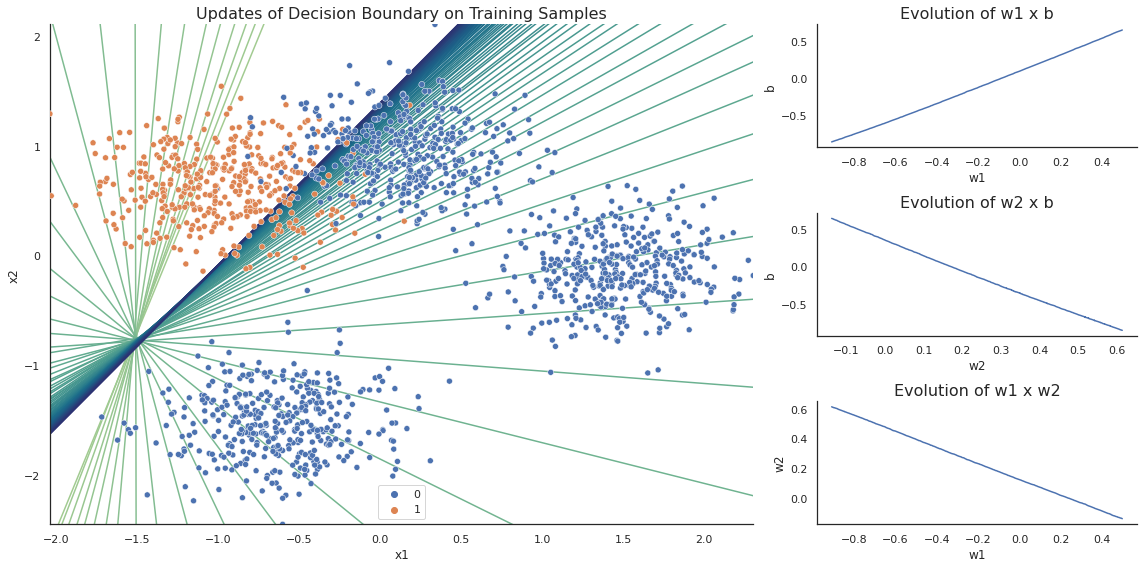

LogisticRegression(learning_rate=0.01, minibatch_size=100, n_epochs=50,
                   optimizer='mini')

In [21]:
clf = LogisticRegression(learning_rate=0.01, optimizer='mini', n_epochs=50, minibatch_size=100)
clf.fit(X_train, y_train, verbose=10)

#### Stochastic

[INFO] epoch=1/1, loss=0.4544300

Final loss: 0.45442997738431484

Mean loss: 0.48300906835945084 +- 0.2881412534521315


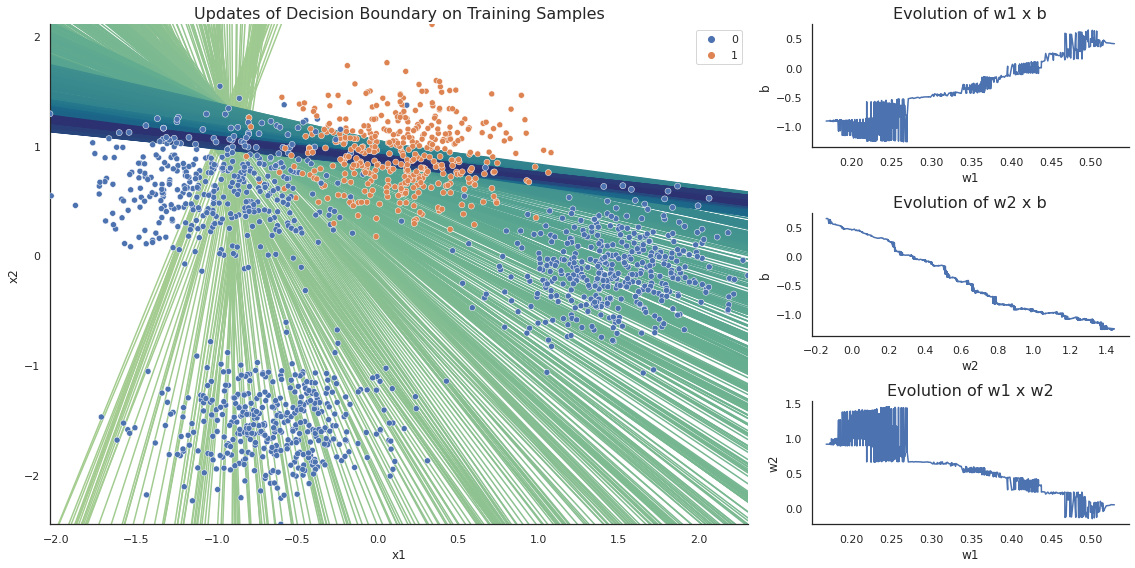

[INFO] epoch=1/1, loss=0.0146908

Final loss: 0.014690788704791602

Mean loss: 0.28214807656991303 +- 0.228203460685539


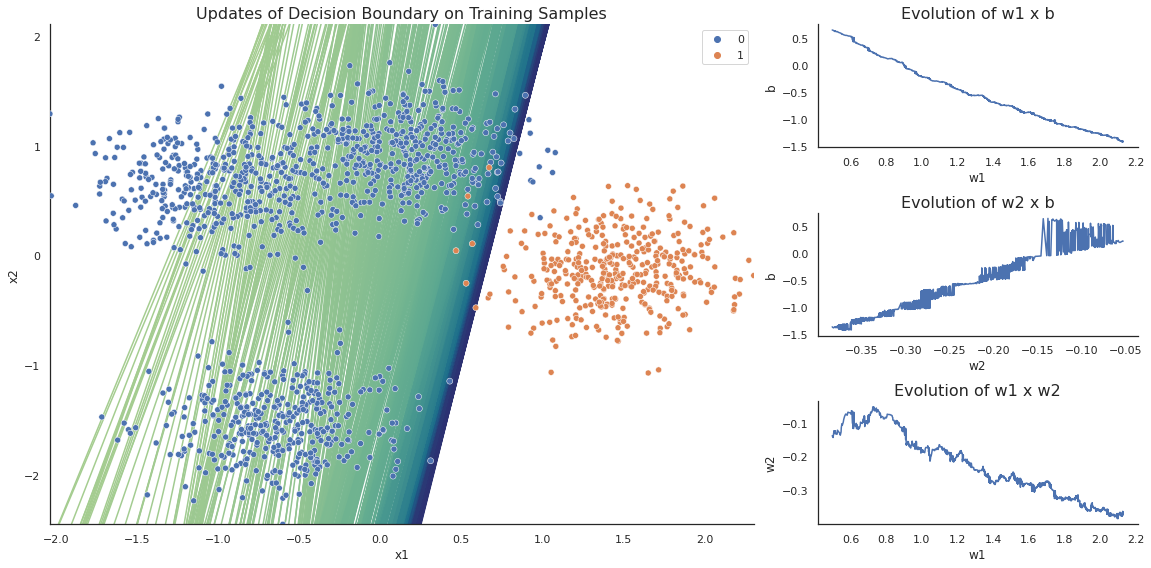

[INFO] epoch=1/1, loss=0.1319367

Final loss: 0.1319367355448481

Mean loss: 0.27245982103304583 +- 0.24749938266468946


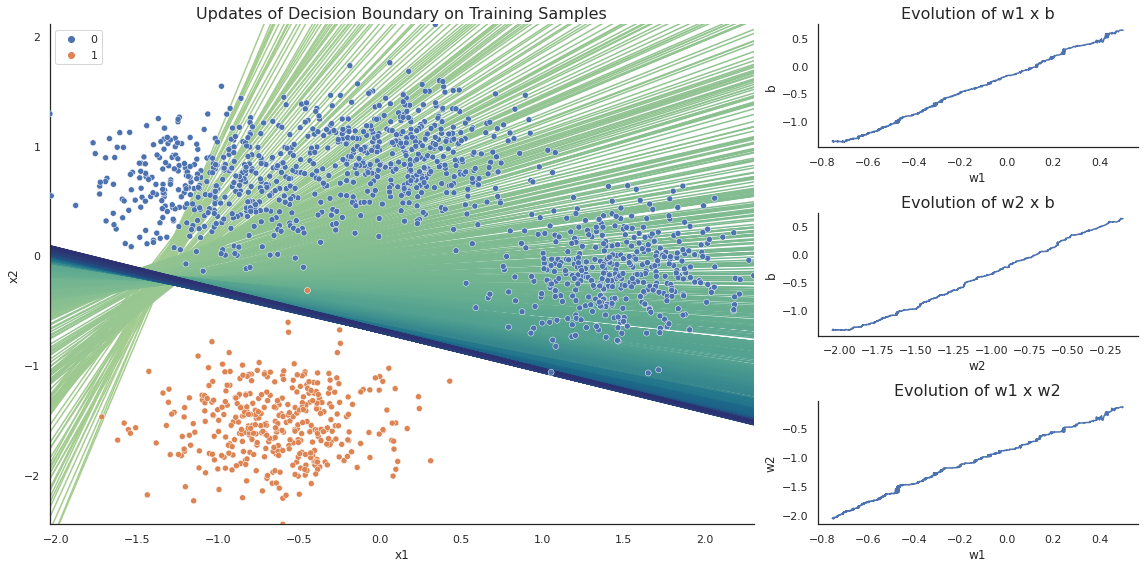

[INFO] epoch=1/1, loss=0.3348522

Final loss: 0.33485224727045554

Mean loss: 0.43195432434542186 +- 0.2737002646217082


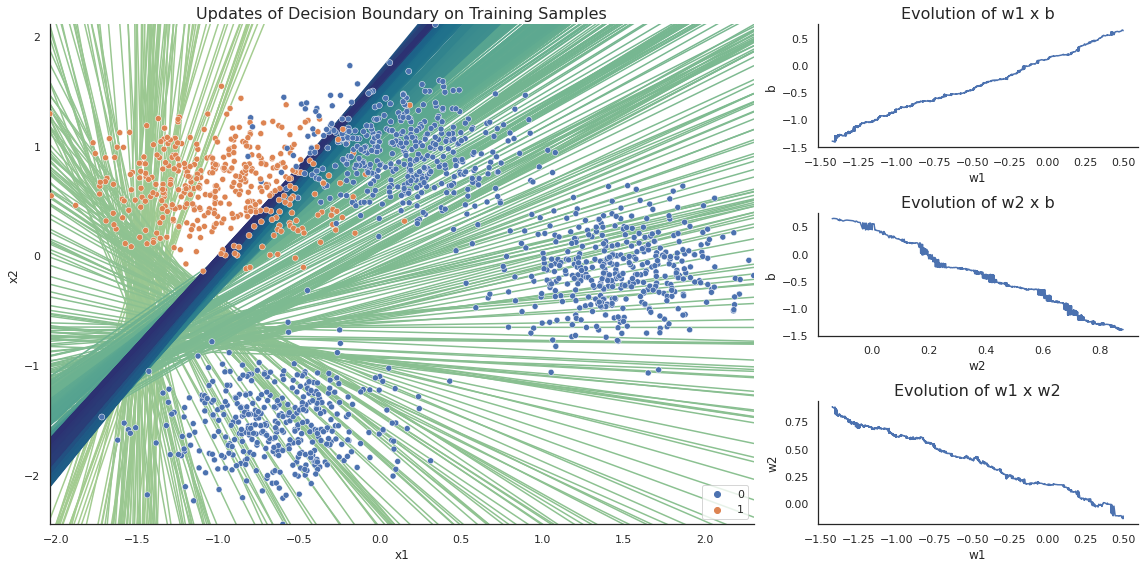

LogisticRegression(learning_rate=0.01, n_epochs=1, optimizer='stochastic')

In [22]:
clf = LogisticRegression(learning_rate=0.01, optimizer='stochastic', n_epochs=1)
clf.fit(X_train, y_train, verbose=1)

### Visualizing the Decision Boundary

$w_1x_1 + w_2x_2 + b = 0$

$x_2 = -(b + w_1x_1)/w_2$

In [23]:
def plot_boundaries(X, y, clf, ax=None):
    if ax == None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, hue_order=clf.classes_, ax=ax)
    
    colors = sns.color_palette()
    for i, (w1, w2), b in zip(range(clf.n_classes_), clf.coef_, clf.intercept_):
        x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
        x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
        sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5)
    ax.set_ylim(X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5)
    
    return ax

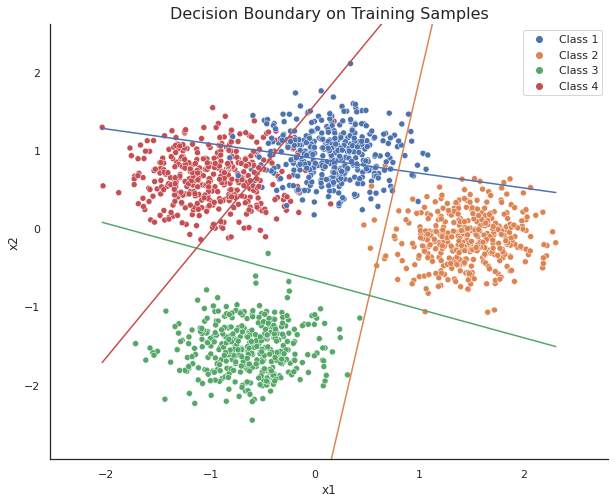

In [24]:
ax = plot_boundaries(X_train, y_train, clf)
plt.title('Decision Boundary on Training Samples')
plt.show()

### Prediction

In [25]:
y_test_pred = clf.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

     Class 1       0.97      0.87      0.92        87
     Class 2       0.96      1.00      0.98       103
     Class 3       1.00      1.00      1.00       112
     Class 4       0.93      0.98      0.96        98

    accuracy                           0.97       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.97      0.97       400



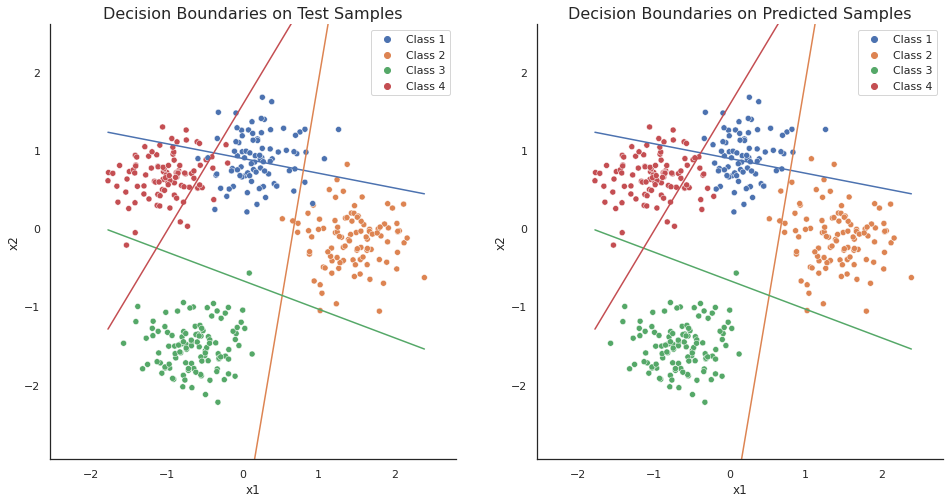

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

plot_boundaries(X_test, y_test, clf, ax=ax[0])
plot_boundaries(X_test, y_test_pred, clf, ax=ax[1])
ax[0].set_title('Decision Boundaries on Test Samples')
ax[1].set_title('Decision Boundaries on Predicted Samples')
plt.show()